# DCM on SUPPORT Dataset

The SUPPORT dataset comes from the Vanderbilt University study to estimate survival for seriously ill hospitalized adults. (Refer to http://biostat.mc.vanderbilt.edu/wiki/Main/SupportDesc. for the original datasource.)

In this notebook, we will apply Deep Cox Mixtures for survival prediction on the SUPPORT data.



In [1]:
from dcm import dcm_tf as dcm

### Load the SUPPORT Dataset

The package includes helper functions to load the dataset.

X represents an np.array of features (covariates), T is the event/censoring times and, E is the censoring indicator. 



In [2]:
dataset = 'SUPPORT'
cv_folds = 5
prot_att = 'race'
fair_strategy = None
quantiles = [0.25, 0.5, 0.75]

from dcm.deep_cox_mixture import load_dataset
(x, t, e, a), folds, times = load_dataset(dataset, cv_folds, prot_att, fair_strategy, quantiles)

x = x.astype('float32')
t = t.astype('float32')

[ 14.  58. 252.]


### Splitting the data into train, test and validation sets
We will train DSM on 70% of the Data, use a Validation set of 10% for Model Selection and report performance on the remaining 20% held out test set.



In [4]:
n = len(x)

tr_size = int(n*0.70)
vl_size = int(n*0.10)
te_size = int(n*0.20)

x_train, x_test, x_val = x[:tr_size], x[-te_size:], x[tr_size:tr_size+vl_size]
t_train, t_test, t_val = t[:tr_size], t[-te_size:], t[tr_size:tr_size+vl_size]
e_train, e_test, e_val = e[:tr_size], e[-te_size:], e[tr_size:tr_size+vl_size]


# Setting up DCM

In the subsequent cell, we will instantiate a class of the `Deep Cox Mixture` model with `k` latent groups and a hidden representation of size of `100`.

In [6]:
k = 3
h = 100

model = dcm.DeepCoxMixture(k, h)

# We `train` the model for 50 epochs, 
# with a learning rate of 1e-3,
# a batch size of 128 using the Adam optimizer.
model, losses = dcm.train(model, 
                  x_train, t_train, e_train, 
                  x_val, t_val, e_val, 
                  epochs=50, lr=1e-3, bs=128, 
                  use_posteriors=False,
                  random_state=0,
                  return_losses=True,
                  patience=3)            

  0%|          | 0/50 [00:00<?, ?it/s]

Instructions for updating:
Use tf.identity instead.


Instructions for updating:
Use tf.identity instead.
 24%|██▍       | 12/50 [01:32<04:52,  7.71s/it]


### Inference

We will infer the survival probability at the quantiles and compute the
metrics of interest.

In [8]:
scores = []

for time in times:
  score = dcm.predict_scores(model, x_test, time)
  scores.append(score)

### Evaluation
We evaluate the performance of DCM in its discriminative ability (Time Dependent Concordance Index and Cumulative Dynamic AUC) as well as Brier Score.



In [9]:
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc
import numpy as np

In [10]:
cis = []
brs = []

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(e_val[i], t_val[i]) for i in range(len(e_val))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, 1-scores[i], times[i])[0])
    

for i, _ in enumerate(times):
    brs.append(float(brier_score(et_train, et_test, scores[i], times[i])[1]))
    
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, 1-scores[i], times[i])[0])
for quantile in enumerate(quantiles):
    print(f"For {quantile[1]} quantile,")
    print("TD Concordance Index:", cis[quantile[0]])
    print("Brier Score:", brs[quantile[0]])
    print("ROC AUC ", roc_auc[quantile[0]][0], "\n")

For 0.25 quantile,
TD Concordance Index: 0.7520614957873781
Brier Score: 0.11212868183423812
ROC AUC  0.765349191348927 

For 0.5 quantile,
TD Concordance Index: 0.6922947029009802
Brier Score: 0.18631449361069802
ROC AUC  0.7133208535470716 

For 0.75 quantile,
TD Concordance Index: 0.6456472732261447
Brier Score: 0.22704216985933723
ROC AUC  0.6875228690858425 



# Plotting Baseline Splines

Here we plot the estimated baseline survival rates for the latent groups.

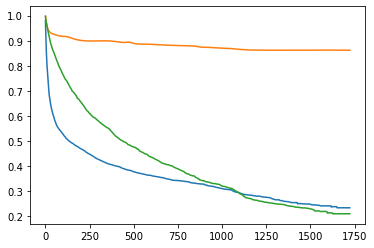

In [11]:
from matplotlib import pyplot as plt
import numpy as np

ts = np.unique(t)

splines = model[1]

for spline in splines:
  plt.plot(splines[spline](ts))
plt.show()